In [1]:
import pandas as pd
import numpy as np

import torch

torch.set_default_dtype(torch.double)

import torch.nn.functional as F
import gpytorch
import botorch

import matplotlib.pyplot as plt

# plt.style.use("ggplot")
# plt.rcParams["figure.figsize"] = (8, 6)

import seaborn as sns

In [2]:
def standardize_y_values(y):
    subtrahend = y.mean()
    divider = y.std()
    return (y - subtrahend) / divider, subtrahend, divider


def normalize_y_values(y):
    subtrahend = y.min()
    divider = y.max() - y.min()
    return (y - subtrahend) / divider, subtrahend, divider

In [3]:
test_path = "../data/DB_10042.csv"
train_path = "../data/Label1000_extended.csv"

In [4]:
test_df = pd.read_csv(test_path, index_col=0).iloc[:, 25:]
train_df = pd.read_csv(train_path, index_col=0)#.iloc[:, ]

/var/folders/wm/cr9_rg9d40sbj5kr5lkgwrlh0000gn/T/ipykernel_6063/2574958251.py:1: DtypeWarning: Columns (2,3,4,5,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_path, index_col=0).iloc[:, 25:]


In [5]:
test_uid = list(test_df.index)
train_uid = list(train_df.index)

train_ind = []

for ind in train_uid:
    if ind in test_uid:
        train_ind.append(test_uid.index(ind))
    else:
        train_df = train_df.drop(index=ind)
        
len(train_ind), train_df.shape

(998, (998, 1045))

In [6]:
train_ind = torch.tensor(train_ind, dtype=torch.long)

# target = "N_400_Storage"
target = "N_300_Storage"
# target = "N_DBD"
# target = "M_Storage"
# target = "M_DBD"
# target = "M_safety"

train_y = torch.tensor(train_df[target].values)

train_y = torch.log(train_y)
# train_y = torch.log(train_y + 1)

train_y, subtrahend, divider = standardize_y_values(train_y)
# train_y = normalize_y_values(train_y)

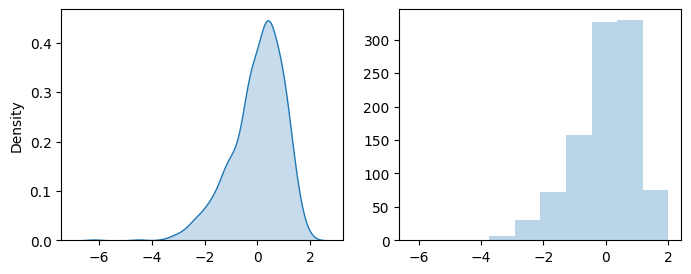

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

sns.kdeplot(train_y, fill=True, ax=ax[0])
ax[1].hist(train_y, alpha=0.3)

plt.show()

# covariance matrix

In [8]:
csv_path = "../data/DB_10042.csv"
node_sim_path = "../data/DB_10042_node_sims2.npy"
linker_sim_path = "../data/DB_10042_linker_sims2.npy"
distributional_sim_path = "../data/DB_10042_distributional_sims.npy"

In [9]:
node_covariance_matrix = torch.tensor(np.load(node_sim_path))
linker_covariance_matrix = torch.tensor(np.load(linker_sim_path))
dist_covariance_matrix = torch.tensor(np.load(distributional_sim_path))

In [10]:
features = torch.tensor(test_df.values)
numerical_features = features[:, :6]
numerical_features = (
    numerical_features - numerical_features.mean(dim=0)
) / numerical_features.std(dim=0)

In [11]:
class NumericalKernel(gpytorch.kernels.Kernel):
    def __init__(self, base_kernel, numerical_features):
        super().__init__()
        self.base_kernel = base_kernel
        self.numerical_features = numerical_features
        
    def forward(self, x1_ind, x2_ind, **params):
        return self.base_kernel(
            self.numerical_features[x1_ind.squeeze(-1), :],
            self.numerical_features[x2_ind.squeeze(-1), :],
            **params
        )
    

class PrecomputedKernel(gpytorch.kernels.Kernel):
    def __init__(self, covariance_matrix):
        super().__init__()
        self.covariance_matrix = covariance_matrix
        
    def forward(self, x1_ind, x2_ind, **params):
        return self.covariance_matrix[x1_ind.squeeze(-1), :][:, x2_ind.squeeze(-1)]

# GP model

In [13]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_ind, train_y, likelihood):
        super().__init__(train_ind, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = (
            gpytorch.kernels.ScaleKernel(
                PrecomputedKernel(node_covariance_matrix)
            )
            + gpytorch.kernels.ScaleKernel(
                PrecomputedKernel(linker_covariance_matrix)
            )
            + gpytorch.kernels.ScaleKernel(
                NumericalKernel(
                    gpytorch.kernels.RBFKernel(ard_num_dims=6),
                    numerical_features,
                )
            ) + gpytorch.kernels.ScaleKernel(
                PrecomputedKernel(dist_covariance_matrix)
            )
        )
        
    def forward(self, ind):
        mean = self.mean_module(ind)
        covar = self.covar_module(ind)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [14]:
train_y.numel()

998

In [15]:
train_r = 0.8

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)

val_train_mask = torch.zeros(train_ind.numel(), dtype=bool)
for mask_i in range(train_ind.numel()):
    val_train_mask[mask_i] = np.random.binomial(1, train_r)

val_train_ind = train_ind[val_train_mask]
val_train_y = train_y[val_train_mask]
val_test_ind = train_ind[~val_train_mask]
val_test_y = train_y[~val_train_mask]
    
val_train_ind.shape, val_test_ind.shape

(torch.Size([795]), torch.Size([203]))

In [ ]:
num_train_iters = 2000

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(val_train_ind, val_train_y, likelihood)

# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
noises = []
mean_constants = []
node_outputscales = []
linker_outputscales = []
numerical_outputscales = []
numerical_lengthscales = []
js_outputscales = []

for i in tqdm(range(num_train_iters)):
    optimizer.zero_grad()

    output = model(val_train_ind)
    loss = -mll(output, val_train_y)

    loss.backward()

    losses.append(loss.item())
    noises.append(model.likelihood.noise.item())
    mean_constants.append(model.mean_module.constant.item()),
    node_outputscales.append(model.covar_module.kernels[0].outputscale.item())
    linker_outputscales.append(model.covar_module.kernels[1].outputscale.item())
    numerical_outputscales.append(model.covar_module.kernels[2].outputscale.item())
    
    this_lengthscales = []
    for lengthscale_i in range(6):
        this_lengthscales.append(
            model.covar_module.kernels[2].base_kernel.base_kernel.lengthscale[0, lengthscale_i].item()
        )
    numerical_lengthscales.append(this_lengthscales)
    
    js_outputscales.append(model.covar_module.kernels[3].outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval();

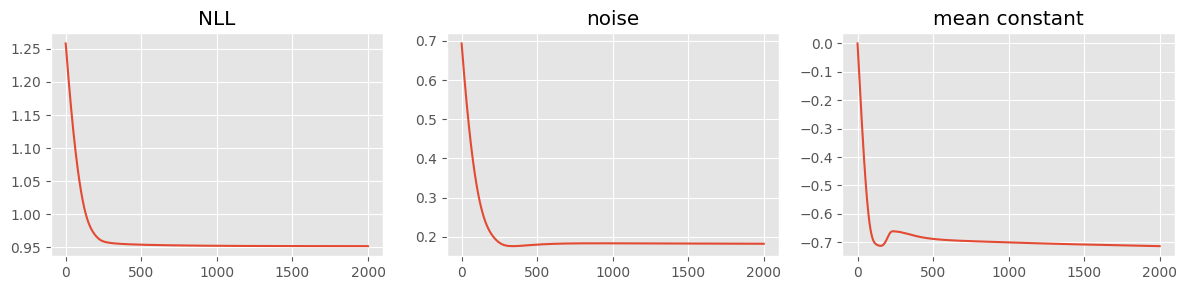

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(losses)
ax[0].set_title("NLL")

ax[1].plot(noises)
ax[1].set_title("noise")

ax[2].plot(mean_constants)
ax[2].set_title("mean constant")

plt.tight_layout()
plt.show()

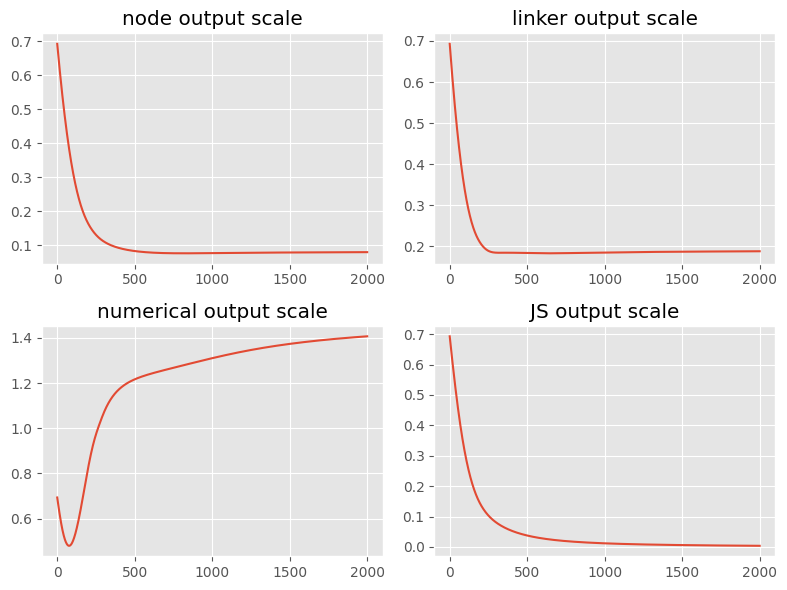

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].plot(node_outputscales)
ax[0, 0].set_title("node output scale")

ax[0, 1].plot(linker_outputscales)
ax[0, 1].set_title("linker output scale")

ax[1, 0].plot(numerical_outputscales)
ax[1, 0].set_title("numerical output scale")

ax[1, 1].plot(js_outputscales)
ax[1, 1].set_title("JS output scale")

plt.tight_layout()
plt.show()

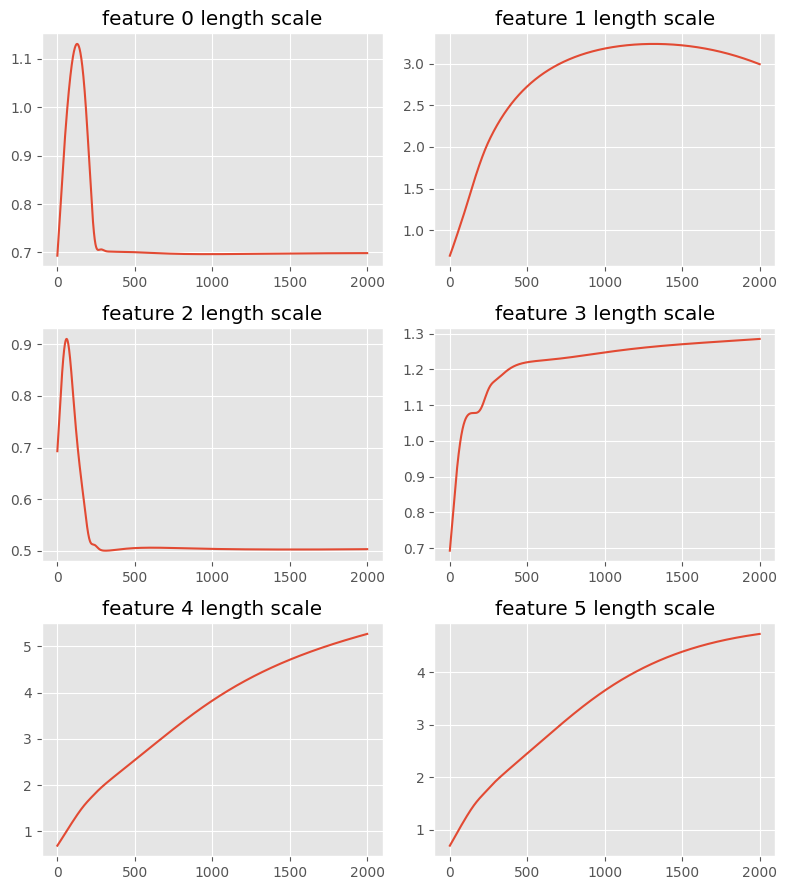

In [18]:
numerical_lengthscale_array = np.array(numerical_lengthscales)

fig, ax = plt.subplots(3, 2, figsize=(8, 9))

for lengthscale_i in range(6):
    this_ax = ax[lengthscale_i // 2][lengthscale_i % 2]
    
    this_ax.plot(numerical_lengthscale_array[:, lengthscale_i])
    this_ax.set_title(f"feature {lengthscale_i} length scale")
    
plt.tight_layout()
plt.show()

In [19]:
with torch.no_grad():
    pred_dist = model(val_test_ind)
    pred_mean = pred_dist.mean
    pred_sd = pred_dist.stddev

In [19]:
real_pred_mean = pred_mean * divider + subtrahend
real_pred_sd = pred_sd * divider
real_val_test_y = val_test_y * divider + subtrahend

NameError: name 'pred_mean' is not defined

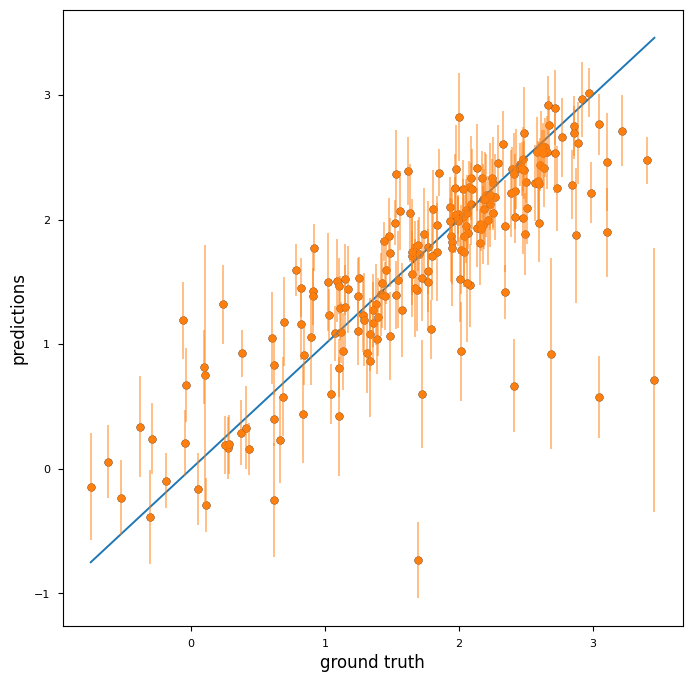

In [24]:
plt.figure(figsize=(8, 8))

plt.scatter(real_val_test_y, real_pred_mean.detach(), c="C1", edgecolor="k")

lower_lim = min(real_val_test_y.min(), real_pred_mean.min())
upper_lim = max(real_val_test_y.max(), real_pred_mean.max())
xs = np.linspace(lower_lim, upper_lim, 101)
plt.plot(xs, xs, c="C0")

plt.errorbar(
    real_val_test_y, 
    real_pred_mean.detach(), 
    yerr=real_pred_sd.detach(), 
    fmt="o",
    c="C1",
    alpha=0.5,
)

plt.xlabel("ground truth")
plt.ylabel("predictions")

plt.show()

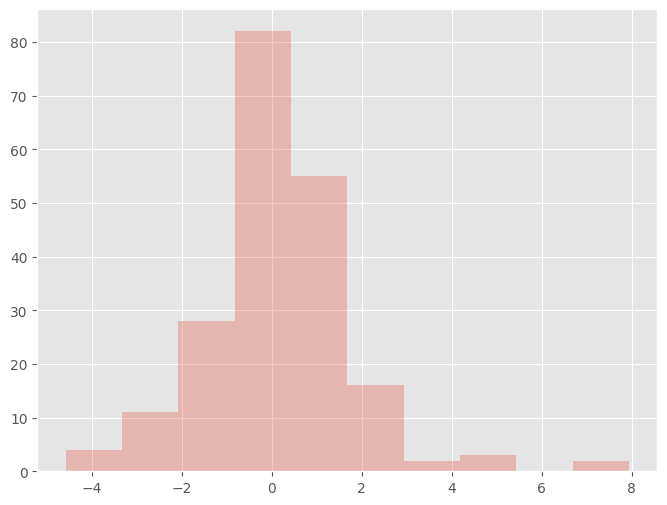

In [22]:
z_scores = (real_val_test_y - real_pred_mean.detach()) / real_pred_sd.detach()

plt.hist(z_scores, alpha=0.3);
# sns.kdeplot(z_scores, fill=True);

In [23]:
mse = ((real_val_test_y - real_pred_mean.detach()) ** 2).mean()
mse

tensor(0.2771)

In [24]:
mae = (real_val_test_y - real_pred_mean.detach()).abs().mean()
mae

tensor(0.3376)

In [25]:
r2 = 1 - (
    ((real_val_test_y - real_pred_mean.detach()) ** 2).sum()
    / ((real_val_test_y - real_val_test_y.mean()) ** 2).sum()
)
r2

tensor(0.6282)

In [27]:
torch.save(real_pred_mean.detach(), f"../data/gp_{target}_mean.pt")
torch.save(real_pred_sd.detach(), f"../data/gp_{target}_sd.pt")

In [16]:
real_val_test_y = val_test_y * divider + subtrahend

real_pred_mean = torch.load(f"../data/gp_{target}_mean.pt")
real_pred_sd = torch.load(f"../data/gp_{target}_sd.pt")

lower_lim = min(real_val_test_y.min(), real_pred_mean.min())
upper_lim = max(real_val_test_y.max(), real_pred_mean.max())
xs = np.linspace(lower_lim, upper_lim, 101)

In [17]:
lr_pred = torch.load("../data/lr_pred.pt")
nn_pred = torch.load("../data/nn_pred.pt")

In [21]:
gp_r2 = 1 - (
    ((real_val_test_y - real_pred_mean.detach()) ** 2).sum()
    / ((real_val_test_y - real_val_test_y.mean()) ** 2).sum()
).item()

lr_r2 = 1 - (
    ((real_val_test_y - lr_pred) ** 2).sum()
    / ((real_val_test_y - real_val_test_y.mean()) ** 2).sum()
).item()

nn_r2 = 1 - (
    ((real_val_test_y - nn_pred) ** 2).sum()
    / ((real_val_test_y - real_val_test_y.mean()) ** 2).sum()
).item()

gp_r2, lr_r2, nn_r2

(0.6282150537951954, 0.23982624713390688, 0.4939119501762591)

In [22]:
plt.style.use("seaborn-v0_8-paper")

params = {
    "figure.figsize": (8, 6),
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
}

plt.rcParams.update(params)

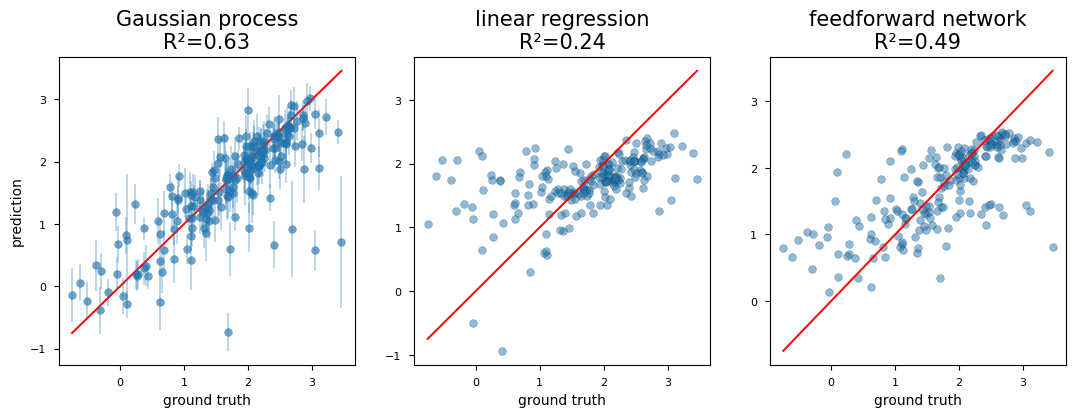

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

ax[0].scatter(
    real_val_test_y,
    real_pred_mean.detach(), 
    # c="C1", 
    edgecolor="k", 
    alpha=0.5,
)

ax[0].plot(xs, xs, c="r")

ax[0].errorbar(
    real_val_test_y, 
    real_pred_mean.detach(), 
    yerr=real_pred_sd.detach(), 
    fmt="o",
    # c="C1",
    alpha=0.3,
)

ax[1].plot(xs, xs, c="r")

ax[1].scatter(
    real_val_test_y,
    lr_pred, 
    # c="C1", 
    edgecolor="k", 
    alpha=0.5,
)

ax[2].plot(xs, xs, c="r")

ax[2].scatter(
    real_val_test_y,
    nn_pred, 
    # c="C1", 
    edgecolor="k", 
    alpha=0.5,
)

ax[0].set_ylabel("prediction", fontsize=10)
ax[0].set_xlabel("ground truth", fontsize=10)
ax[1].set_xlabel("ground truth", fontsize=10)
ax[2].set_xlabel("ground truth", fontsize=10)

ax[0].set_title("Gaussian process\nR²=" + f"{gp_r2:.2f}", fontsize=15)
ax[1].set_title("linear regression\nR²=" + f"{lr_r2:.2f}", fontsize=15)
ax[2].set_title("feedforward network\nR²=" + f"{nn_r2:.2f}", fontsize=15)

plt.show()

In [18]:
targets = ["M_Storage", "M_DBD", "M_safety"]

train_ys = [
    torch.tensor(train_df["M_Storage"].values),
    torch.log(torch.tensor(train_df["M_DBD"].values)),
    torch.log(torch.tensor(train_df["M_safety"].values) + 1),
]
# train_ys = [torch.tensor(train_df[t].values) for t in targets]

real_pred_means = [torch.load(f"../data/gp_{t}_mean.pt") for t in targets]
real_pred_sds = [torch.load(f"../data/gp_{t}_sd.pt") for t in targets]

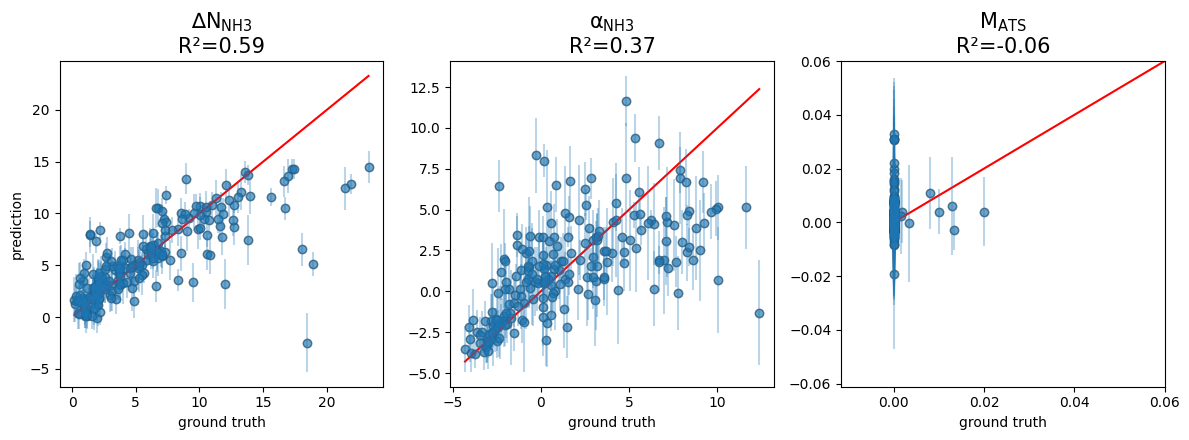

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4.5))

objective_names = [r"${\rm ∆N}_{\rm NH3}$", r"${\rm \alpha}_{\rm NH3}$", r"${\rm M}_{\rm ATS}$"]

for i, t in enumerate(targets):
    lower_lim = min(train_ys[i][~val_train_mask].min(), train_ys[i][~val_train_mask].min())
    upper_lim = max(train_ys[i][~val_train_mask].max(), train_ys[i][~val_train_mask].max())
    xs = np.linspace(lower_lim, upper_lim, 101)
    
    r2 = 1 - (
        ((train_ys[i][~val_train_mask] - real_pred_means[i].detach()) ** 2).sum()
        / ((train_ys[i][~val_train_mask] - train_ys[i][~val_train_mask].mean()) ** 2).sum()
    ).item()
    
    ax[i].scatter(
        train_ys[i][~val_train_mask],
        real_pred_means[i].detach(), 
        # c="C1", 
        edgecolor="k", 
        alpha=0.5,
    )

    ax[i].plot(xs, xs, c="r")

    ax[i].errorbar(
        train_ys[i][~val_train_mask],
        real_pred_means[i].detach(), 
        yerr=real_pred_sds[i].detach(), 
        fmt="o",
        # c="C1",
        alpha=0.3,
    )

    # ax[i].set_aspect("equal")
    ax[i].set_xlabel("ground truth", fontsize=10)
    ax[i].set_title(objective_names[i] + "\nR²=" + f"{r2:.2f}", fontsize=15)

ax[0].set_ylabel("prediction", fontsize=10)
ax[2].set_xlim(ax[2].get_xlim()[0], 0.06)
ax[2].set_ylim(ax[2].get_ylim()[0], 0.06)

plt.tight_layout()
plt.show()